# NB03: Conservation Analysis — Metal-Specific vs General Stress

Test H1a/H1b: Do metal-specific genes show different core/accessory distribution
than general stress genes?

**Pitfalls addressed**:
- Core denominator matches Metal Atlas methodology (mapped genes only)
- Essential genes (~14%, ~82% core) are invisible — reported as caveat
- Fisher exact test per organism + Cochran-Mantel-Haenszel meta-analysis

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')

# Gene specificity from NB02
spec = pd.read_csv(os.path.join(DATA_OUT, 'gene_specificity_classification.csv'))
print(f'Gene specificity records: {len(spec)}')

# FB-pangenome links (core/accessory status)
link = pd.read_csv(os.path.join(MAIN_REPO, 'projects', 'conservation_vs_fitness', 'data', 'fb_pangenome_link.tsv'), sep='\t')
print(f'FB-pangenome links: {len(link)}')
print(f'  Organisms with links: {link["orgId"].nunique()}')

# Metal atlas conservation stats for comparison
atlas_cons = pd.read_csv(os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data', 'metal_conservation_stats.csv'))
print(f'\nAtlas conservation stats (for comparison):')
print(atlas_cons[['metal', 'n_important', 'core_frac_important', 'core_frac_baseline']].to_string(index=False))

In [2]:
# Gene specificity from NB02
spec = pd.read_csv(os.path.join(DATA_OUT, 'gene_specificity_classification.csv'))
print(f'Gene specificity records: {len(spec)}')

# FB-pangenome links (core/accessory status)
link = pd.read_csv(os.path.join(MAIN_REPO, 'projects', 'conservation_vs_fitness', 'data', 'fb_pangenome_link.tsv'), sep='\t')
print(f'FB-pangenome links: {len(link)}')
print(f'  Organisms with links: {link["orgId"].nunique()}')
print(f'  Columns: {link.columns.tolist()}')

# Metal atlas conservation stats for comparison
atlas_cons = pd.read_csv(os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data', 'metal_conservation_stats.csv'))
print(f'\nAtlas conservation stats (for comparison):')
print(atlas_cons[['metal', 'n_important', 'core_frac_important', 'core_frac_baseline']].to_string(index=False))

Gene specificity records: 7609


FB-pangenome links: 177863
  Organisms with links: 44
  Columns: ['orgId', 'locusId', 'gene_cluster_id', 'gtdb_species_clade_id', 'pident', 'evalue', 'bitscore', 'is_core', 'is_auxiliary', 'is_singleton']

Atlas conservation stats (for comparison):
     metal  n_important  core_frac_important  core_frac_baseline
  Aluminum         1381             0.897900            0.791245
   Cadmium           92             0.521739            0.531466
  Chromium          262             0.709924            0.650042
    Cobalt         1859             0.858526            0.786096
    Copper         2139             0.866760            0.776268
      Iron          651             0.918587            0.802790
 Manganese           30             1.000000            0.801850
   Mercury          106             0.933962            0.801850
Molybdenum          302             0.950331            0.801850
    Nickel         1760             0.876705            0.788776
  Selenium          134             

## Join specificity with conservation status

In [3]:
# Merge specificity with pangenome link
spec_cons = spec.merge(link[['orgId', 'locusId', 'is_core']], on=['orgId', 'locusId'], how='inner')
print(f'Genes with both specificity and conservation data: {len(spec_cons)}')
print(f'Organisms: {spec_cons["orgId"].nunique()}')
print(f'Lost {len(spec) - len(spec_cons)} genes without pangenome links')

# Overall core fraction by specificity category
print(f'\n=== Core fraction by specificity (5% threshold) ===')
for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    sub = spec_cons[spec_cons.specificity_5pct == cat]
    n = len(sub)
    n_core = sub['is_core'].sum()
    pct = 100 * n_core / n if n > 0 else 0
    print(f'  {cat:20s}: {n_core:5d} / {n:5d} core ({pct:.1f}%)')

# Baseline: all genes with pangenome links for these organisms
orgs_with_spec = set(spec_cons['orgId'].unique())
baseline = link[link.orgId.isin(orgs_with_spec)]
baseline_core = baseline['is_core'].sum() / len(baseline) * 100
print(f'\n  Baseline (all mapped genes): {baseline["is_core"].sum()} / {len(baseline)} core ({baseline_core:.1f}%)')

Genes with both specificity and conservation data: 6415
Organisms: 22
Lost 1194 genes without pangenome links

=== Core fraction by specificity (5% threshold) ===
  metal_specific      :  2969 /  3500 core (84.8%)
  metal_plus_stress   :   467 /   495 core (94.3%)
  general_sick        :  2183 /  2420 core (90.2%)

  Baseline (all mapped genes): 73957 / 92650 core (79.8%)


## Per-organism conservation analysis

In [4]:
# Per-organism Fisher exact test: metal-specific vs baseline
org_results = []

for org in sorted(spec_cons['orgId'].unique()):
    org_spec = spec_cons[spec_cons.orgId == org]
    org_base = link[link.orgId == org]
    
    for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
        sub = org_spec[org_spec.specificity_5pct == cat]
        n = len(sub)
        if n < 5:  # Skip categories with too few genes
            continue
        n_core = sub['is_core'].sum()
        n_acc = n - n_core
        
        # Baseline for this organism (all mapped genes NOT in this category)
        base_core = org_base['is_core'].sum() - n_core
        base_acc = len(org_base) - org_base['is_core'].sum() - n_acc
        
        # Fisher exact test
        table = [[n_core, n_acc], [base_core, base_acc]]
        if all(x >= 0 for row in table for x in row):
            odds_ratio, p_value = stats.fisher_exact(table)
        else:
            odds_ratio, p_value = np.nan, np.nan
        
        core_frac = n_core / n if n > 0 else 0
        base_frac = org_base['is_core'].mean()
        delta = core_frac - base_frac
        
        org_results.append({
            'orgId': org,
            'specificity': cat,
            'n_genes': n,
            'n_core': n_core,
            'core_fraction': core_frac,
            'baseline_core': base_frac,
            'delta': delta,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
        })

org_res_df = pd.DataFrame(org_results)
print(f'Per-organism results: {len(org_res_df)} records')

# Summary by category
print(f'\n=== Mean core fraction by specificity category (across organisms) ===')
for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    sub = org_res_df[org_res_df.specificity == cat]
    if len(sub) > 0:
        mean_core = sub['core_fraction'].mean()
        mean_delta = sub['delta'].mean()
        n_sig = (sub['p_value'] < 0.05).sum()
        n_pos = (sub['delta'] > 0).sum()
        print(f'  {cat:20s}: mean core={mean_core:.3f}, mean delta={mean_delta:+.3f}, '
              f'{n_pos}/{len(sub)} positive, {n_sig}/{len(sub)} significant (p<0.05)')

Per-organism results: 56 records

=== Mean core fraction by specificity category (across organisms) ===
  metal_specific      : mean core=0.880, mean delta=+0.069, 19/22 positive, 12/22 significant (p<0.05)
  metal_plus_stress   : mean core=0.936, mean delta=+0.109, 13/13 positive, 1/13 significant (p<0.05)
  general_sick        : mean core=0.902, mean delta=+0.090, 21/21 positive, 8/21 significant (p<0.05)


In [5]:
# Detailed per-organism table for metal-specific genes
ms_results = org_res_df[org_res_df.specificity == 'metal_specific'].sort_values('delta', ascending=False)
print('Metal-specific genes — per-organism conservation:')
print(ms_results[['orgId', 'n_genes', 'core_fraction', 'baseline_core', 'delta', 'odds_ratio', 'p_value']].to_string(index=False))

Metal-specific genes — per-organism conservation:
             orgId  n_genes  core_fraction  baseline_core     delta  odds_ratio      p_value
            Btheta      134       0.828358       0.654749  0.173609    2.602270 7.884714e-06
      pseudo6_N2E2      143       0.958042       0.800936  0.157106    5.851474 5.505827e-08
pseudo13_GW456_L13       72       0.986111       0.833918  0.152193   14.449453 4.230751e-05
             BFirm      102       0.882353       0.753136  0.129217    2.483635 1.630682e-03
           Cup4G11      411       0.759124       0.644775  0.114349    1.789407 4.042062e-07
  Methanococcus_S2       44       0.954545       0.842474  0.112072    4.014265 3.549913e-02
             Phaeo       89       0.977528       0.867120  0.110408    6.818773 6.789709e-04
  Methanococcus_JJ       92       0.913043       0.802713  0.110330    2.680015 4.491416e-03
               DvH      332       0.924699       0.818153  0.106545    2.958653 1.168699e-08
            Marino  

In [6]:
# Cochran-Mantel-Haenszel test for overall association
# Compare metal-specific vs general-sick for core enrichment, stratified by organism
from scipy.stats import chi2

def cochran_mantel_haenszel(df, cat1, cat2):
    """CMH test comparing core enrichment between two specificity categories across organisms."""
    numerator = 0
    denominator = 0
    
    for org in df['orgId'].unique():
        org_data = df[df.orgId == org]
        c1 = org_data[org_data.specificity == cat1]
        c2 = org_data[org_data.specificity == cat2]
        
        if len(c1) == 0 or len(c2) == 0:
            continue
        
        a = c1['n_core'].values[0]  # cat1 core
        b = c1['n_genes'].values[0] - a  # cat1 accessory
        c = c2['n_core'].values[0]  # cat2 core
        d = c2['n_genes'].values[0] - c  # cat2 accessory
        
        n = a + b + c + d
        if n == 0:
            continue
        
        E_a = (a + b) * (a + c) / n
        V_a = (a + b) * (c + d) * (a + c) * (b + d) / (n**2 * (n - 1)) if n > 1 else 0
        
        numerator += (a - E_a)
        denominator += V_a
    
    if denominator == 0:
        return np.nan, np.nan
    
    cmh_stat = numerator**2 / denominator
    p = 1 - chi2.cdf(cmh_stat, df=1)
    return cmh_stat, p

cmh_stat, cmh_p = cochran_mantel_haenszel(org_res_df, 'metal_specific', 'general_sick')
print(f'CMH test (metal-specific vs general-sick):')
print(f'  Chi-squared statistic: {cmh_stat:.2f}')
print(f'  p-value: {cmh_p:.2e}')

cmh_stat2, cmh_p2 = cochran_mantel_haenszel(org_res_df, 'metal_specific', 'metal_plus_stress')
print(f'\nCMH test (metal-specific vs metal+stress):')
print(f'  Chi-squared statistic: {cmh_stat2:.2f}')
print(f'  p-value: {cmh_p2:.2e}')

CMH test (metal-specific vs general-sick):
  Chi-squared statistic: 6.42
  p-value: 1.13e-02

CMH test (metal-specific vs metal+stress):
  Chi-squared statistic: 2.09
  p-value: 1.48e-01


## Visualization

/tmp/ipykernel_14565/1475436342.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(plot_data, labels=cat_labels, patch_artist=True, widths=0.6)
/tmp/ipykernel_14565/1475436342.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(delta_data, labels=cat_labels, patch_artist=True, widths=0.6)


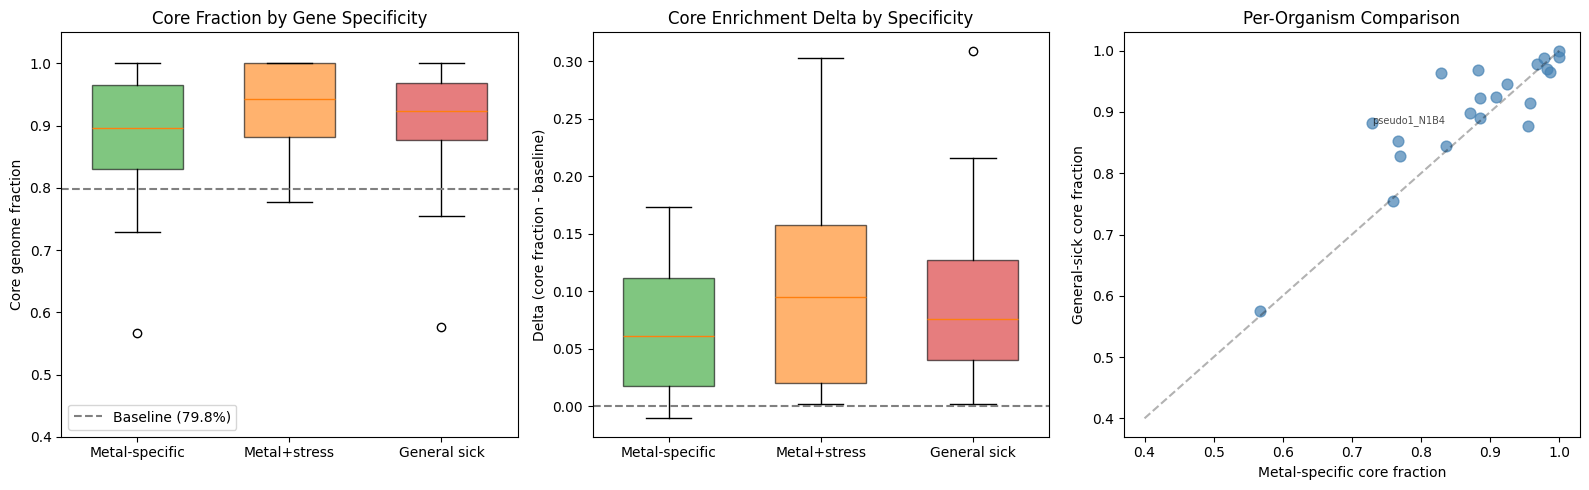

Saved: figures/conservation_by_specificity.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Core fraction by specificity category (boxplot across organisms)
cat_order = ['metal_specific', 'metal_plus_stress', 'general_sick']
cat_labels = ['Metal-specific', 'Metal+stress', 'General sick']
cat_colors = ['#2ca02c', '#ff7f0e', '#d62728']

plot_data = []
for cat in cat_order:
    sub = org_res_df[org_res_df.specificity == cat]
    plot_data.append(sub['core_fraction'].values)

bp = axes[0].boxplot(plot_data, labels=cat_labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], cat_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Add baseline line
axes[0].axhline(y=baseline_core/100, color='gray', linestyle='--', label=f'Baseline ({baseline_core:.1f}%)')
axes[0].set_ylabel('Core genome fraction')
axes[0].set_title('Core Fraction by Gene Specificity')
axes[0].legend(loc='lower left')
axes[0].set_ylim(0.4, 1.05)

# Panel 2: Delta (core fraction - baseline) by category
delta_data = []
for cat in cat_order:
    sub = org_res_df[org_res_df.specificity == cat]
    delta_data.append(sub['delta'].values)

bp2 = axes[1].boxplot(delta_data, labels=cat_labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp2['boxes'], cat_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].axhline(y=0, color='gray', linestyle='--')
axes[1].set_ylabel('Delta (core fraction - baseline)')
axes[1].set_title('Core Enrichment Delta by Specificity')

# Panel 3: Per-organism comparison (metal-specific vs general-sick)
ms = org_res_df[org_res_df.specificity == 'metal_specific'].set_index('orgId')
gs = org_res_df[org_res_df.specificity == 'general_sick'].set_index('orgId')
common_orgs = sorted(set(ms.index) & set(gs.index))

if common_orgs:
    x = [ms.loc[org, 'core_fraction'] for org in common_orgs]
    y = [gs.loc[org, 'core_fraction'] for org in common_orgs]
    axes[2].scatter(x, y, c='steelblue', s=60, alpha=0.7)
    axes[2].plot([0.4, 1], [0.4, 1], 'k--', alpha=0.3)
    axes[2].set_xlabel('Metal-specific core fraction')
    axes[2].set_ylabel('General-sick core fraction')
    axes[2].set_title('Per-Organism Comparison')
    # Label outliers
    for org, xi, yi in zip(common_orgs, x, y):
        if abs(xi - yi) > 0.15:
            axes[2].annotate(org, (xi, yi), fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'conservation_by_specificity.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/conservation_by_specificity.png')

## Stratify by metal type (exploratory)

In [8]:
# Join metal info with specificity and conservation
metal_genes = pd.read_csv(os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data', 'metal_important_genes.csv'))
metal_info = metal_genes[['orgId', 'locusId', 'metal_element']].drop_duplicates()

# Metal categories from the atlas
ESSENTIAL_METALS = {'Iron', 'Molybdenum', 'Tungsten', 'Selenium', 'Manganese'}
TOXIC_METALS = {'Cobalt', 'Nickel', 'Copper', 'Zinc', 'Aluminum', 'Chromium', 'Uranium', 'Mercury', 'Cadmium'}

# For genes with conservation data, add metal type
spec_cons_metal = spec_cons.merge(metal_info, on=['orgId', 'locusId'], how='inner')
spec_cons_metal['metal_type'] = spec_cons_metal['metal_element'].apply(
    lambda m: 'essential' if m in ESSENTIAL_METALS else 'toxic'
)

print('Core fraction by specificity × metal type:')
for mtype in ['toxic', 'essential']:
    print(f'\n  {mtype.upper()} metals:')
    sub = spec_cons_metal[spec_cons_metal.metal_type == mtype]
    for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
        csub = sub[sub.specificity_5pct == cat]
        if len(csub) > 0:
            pct = 100 * csub['is_core'].mean()
            print(f'    {cat:20s}: {csub["is_core"].sum():5d} / {len(csub):5d} core ({pct:.1f}%)')

print(f'\n  Note: Essential metals are dominated by DvH (608 non-metal exps),'
      f' causing 0% metal-specific classification for Mo/W/Se/Mn/Hg.'
      f' This is an experiment-count bias, not a biological signal.')

Core fraction by specificity × metal type:

  TOXIC metals:
    metal_specific      :  3693 /  4432 core (83.3%)
    metal_plus_stress   :   227 /   242 core (93.8%)
    general_sick        :  4118 /  4620 core (89.1%)

  ESSENTIAL metals:
    metal_specific      :   533 /   569 core (93.7%)
    metal_plus_stress   :   316 /   335 core (94.3%)
    general_sick        :   478 /   516 core (92.6%)

  Note: Essential metals are dominated by DvH (608 non-metal exps), causing 0% metal-specific classification for Mo/W/Se/Mn/Hg. This is an experiment-count bias, not a biological signal.


In [9]:
# Save results
org_res_df.to_csv(os.path.join(DATA_OUT, 'specificity_conservation.csv'), index=False)
print(f'Saved: data/specificity_conservation.csv ({len(org_res_df)} records)')

# Summary for the report
print(f'\n=== KEY RESULTS ===')
for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    sub = spec_cons[spec_cons.specificity_5pct == cat]
    n = len(sub)
    n_core = sub['is_core'].sum()
    pct = 100 * n_core / n if n > 0 else 0
    print(f'{cat:20s}: {pct:.1f}% core (n={n})')
print(f'{"baseline":20s}: {baseline_core:.1f}% core (n={len(baseline)})')
print(f'\nEssential gene caveat: ~14% of genes (~82% core) are putatively essential')
print(f'and absent from fitness data. This biases all categories toward core enrichment.')

Saved: data/specificity_conservation.csv (56 records)

=== KEY RESULTS ===
metal_specific      : 84.8% core (n=3500)
metal_plus_stress   : 94.3% core (n=495)
general_sick        : 90.2% core (n=2420)
baseline            : 79.8% core (n=92650)

Essential gene caveat: ~14% of genes (~82% core) are putatively essential
and absent from fitness data. This biases all categories toward core enrichment.
